<a href="https://colab.research.google.com/github/ktongk/BTT-JPMC-1/blob/Katrina/Sector_of_scrape_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Obtaining a list of equities tickers and the corresponding timeseries

In [2]:
! pip install --quiet yfinance ##--quiet mutes the package list as it’s installing

In [120]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

import seaborn as sns
sns.set(rc={'figure.figsize':(10,8)})
import matplotlib.pyplot as plt


from datetime import datetime
''
# this workaround let's us override pandas_datareader with yfinance,
# although we can also use yfinance directly
import yfinance as yf
import pandas_datareader.data as web; yf.pdr_override()

In [4]:
start_date = '2023-03-02'
end_date  = '2023-03-21'

data_dir = '/data/'

#<font color="Grey">**A Timeline on the SVB Crash and why we chose it**

According to Investopedia, SVB Financial Group was removed from the S&P 500 Index due to the collapse its bank. So the most recent rebalancing of S&P 500 was announced on March 10, 2023.

The bank, mostly focused on venture capital funds and small tech startups had a huge boom during the pandemic. The bank then invested all of its profits into low-return bonds. However, after aggressive federal rate hikes the bonds quickly lost their value, causing panic. SVB no longer had the cash to give to the companies withdrawing their money and the FDIC took over the bank.


Initally the FDIC could only insure up to 250k but that wasn't enough, causing fear of a 2008 recession. The fed, treasury, and FDIC then announced a new emergency lending program so every company could get their money back.

##<font color = "green">**Timeseries Length** </font>
Originally, our team was going to do the entire month of march but, because there was a distinct end, it didn't seem necesarry to do the full month. We decided to do a week before SVB announced their losses and then around a week after the emergency lending program was announced.

##<font color = "#D80000"> **What other events did we consider?** </font>



Our team wanted to pick an event that had both positive and negative affects on the S&P500 companies and had a distinct beginning and end (within a reasonably small window).

We considered doing the pandemic but it was too long and the rise of ChatGPT but there were too many factors to consider (3.5 release, 4.0 release, 3.5 gets worse)
See article:

> See article: https://arxiv.org/pdf/2307.09009.pdf

In [5]:
names = ['','SVB announces 1.8 billion loss on bonds', 'SVB shares fall 60%, depositors withdraw money',
         'FDIC takes over SVB only insures up to 250k', 'Fed, Tresury, & FDIC say theyll cover all deposits',
         'Bank stocks bounced back in early trading','',
        ]

dates = ['2023-03-07','2023-03-08', '2023-03-09', '2023-03-10',
             '2023-03-12', '2023-03-14','2023-03-15'
        ]

    # Convert date strings (e.g. 2014-10-18) to datetime
    #import in above cell
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates] #strptime takes in date and format

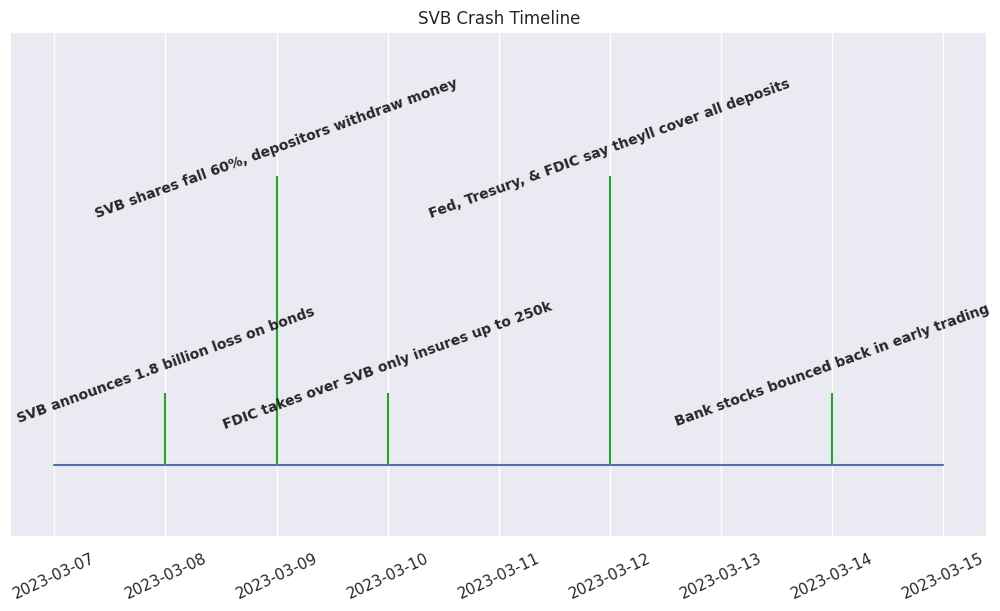

In [6]:
levels = np.tile([0, 1,4, 1, 4,1, 0], int(np.ceil(len(dates)/5)))[:len(dates)]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")
ax.set(title="SVB Crash Timeline")

ax.vlines(dates, 0, levels, color="tab:green")  # The vertical stems.
ax.plot(dates, np.zeros_like(dates))  # Baseline and markers on it.



for d, l, r in zip(dates, levels, names):
    ax.annotate(r, xy=(d, l), xytext=(0, 1* 20),# 0 means no horizontal offset and 1*20 means annotation will be 20 spaces from the end of the stem
                textcoords="offset points", horizontalalignment="center",
                verticalalignment="center", rotation=20, fontsize = 10, weight="bold")  # Rotate the text by 45 degrees

ax.set_ylim(-1, 6)
ax.yaxis.set_visible(False)
plt.xticks(rotation=25)
plt.show()

## Google trend search of the keyword "svb"

In [7]:
#svb_google = pd.read_csv('/content/sample_data/svb_google_trend.csv')

#import matplotlib.dates as mdates

In [8]:
'''
svb_google['Day'] = pd.to_datetime(svb_google['Day'])

# Filter the DataFrame to only include dates at a five-day interval
df_filtered = svb_google[svb_google['Day'].dt.day % 1 == 0]

x = df_filtered['Day']
y = df_filtered['SVB: (District of Columbia)']


# Create a DateFormatter object
date_formatter = mdates.DateFormatter('%m-%d')

# Set the DateFormatter as the major formatter for the x-axis
plt.gca().xaxis.set_major_formatter(date_formatter)

plt.plot(x, y)

plt.xlabel('Date')
plt.ylabel('Interest Over Time')

plt.title('Interest over time of "SVB"')

plt.show()'''


'\nsvb_google[\'Day\'] = pd.to_datetime(svb_google[\'Day\'])\n\n# Filter the DataFrame to only include dates at a five-day interval\ndf_filtered = svb_google[svb_google[\'Day\'].dt.day % 1 == 0]\n\nx = df_filtered[\'Day\']\ny = df_filtered[\'SVB: (District of Columbia)\']\n\n\n# Create a DateFormatter object\ndate_formatter = mdates.DateFormatter(\'%m-%d\')\n\n# Set the DateFormatter as the major formatter for the x-axis\nplt.gca().xaxis.set_major_formatter(date_formatter)\n\nplt.plot(x, y)\n\nplt.xlabel(\'Date\')\nplt.ylabel(\'Interest Over Time\')\n\nplt.title(\'Interest over time of "SVB"\')\n\nplt.show()'

## <font color = "990099"> **Get list of companies in S&P500** </font>

Our team will obtain and store the list of the constituents from Wikipedia.

In [9]:
data    = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#S%26P_500_component_stocks')
table_symbol   = data[0]
table_industry = data[0]['GICS Sector']
symbols = list(table_symbol.Symbol.values) ##companies
industries = list(table_industry.values) ##Industry Sector

symbols_industries_dict = {}
symbols_industries = data[0].iloc[:, [0,2]].values.tolist()
for pair in symbols_industries:
  keys, values = pair
  symbols_industries_dict[keys] = values

print("{} symbols in total".format(len(symbols)))
print("{} industries in total".format(len(industries)))
print(industries)


503 symbols in total
503 industries in total
['Industrials', 'Industrials', 'Health Care', 'Health Care', 'Information Technology', 'Communication Services', 'Consumer Staples', 'Information Technology', 'Industrials', 'Utilities', 'Financials', 'Health Care', 'Consumer Discretionary', 'Materials', 'Information Technology', 'Industrials', 'Materials', 'Real Estate', 'Health Care', 'Industrials', 'Utilities', 'Financials', 'Communication Services', 'Communication Services', 'Consumer Staples', 'Consumer Discretionary', 'Materials', 'Information Technology', 'Utilities', 'Industrials', 'Utilities', 'Financials', 'Financials', 'Real Estate', 'Utilities', 'Financials', 'Industrials', 'Health Care', 'Information Technology', 'Information Technology', 'Information Technology', 'Financials', 'Energy', 'Information Technology', 'Information Technology', 'Consumer Discretionary', 'Financials', 'Information Technology', 'Financials', 'Financials', 'Communication Services', 'Utilities', 'Informat

## <font color = "6666FF"> **Download price timeseries** </font>

Now that we have a list of ticker symbols, we can download the corresponding timeseries from Yahoo Finance.

In [10]:
# Kassi said to get rid of this one because this is the index itself
#symbols.append('SPY')

In [11]:
dates = '_{}--{}'.format(start_date, end_date)
dates

'_2023-03-02--2023-03-21'

In [12]:
'''
try:
  os.mkdir(data_dir)
except:
  print("Dir Error")
  '''
os.makedirs(data_dir, exist_ok=True)


In [13]:
#!ls /data

**Load all the company data files:**

In [14]:
symbols = sorted(symbols)
print("Downloading {} files".format(len(symbols)))
for i, symbol in enumerate(symbols):
    try:
        df = web.get_data_yahoo(symbol, start_date, end_date,)
        # df = web.DataReader(symbol,'yahoo', start_date, end_date)
        df = df[['Adj Close','Volume']]
        df.to_csv(os.path.join(data_dir, "{}.csv".format(symbol)))
    except KeyError:
      print("Error for {}".format(symbol))
      pass
print("Stored {} files".format(i+1))



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2023-03-02 -> 2023-03-21)')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['KVUE']: Exception("%ticker%: Data doesn't exist for startDate = 1677733200, endDate = 1679371200")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

In [15]:
# Printing a sample dataframe
idx = np.random.randint(len(symbols))
print("History for {}".format(symbols[idx]))
df = pd.read_csv(os.path.join(data_dir, symbols[idx]+".csv")).set_index('Date')
df.head()

History for FLT


,Adj Close,Volume
Date,,
2023-03-02,212.500000,930100
2023-03-03,214.720001,599900
2023-03-06,211.779999,601300
2023-03-07,209.169998,611200
2023-03-08,208.949997,505400


## <font color= "CC0099">**Pre-process Financial Timeseries:**

In [16]:
index = pd.date_range(start=start_date, end=end_date, freq='D')     # initialize an empty DateTime Index and so each index is a date over the month
df_price = pd.DataFrame(index=index, columns=symbols)               # initialize empty dataframes
df_volume = pd.DataFrame(index=index, columns=symbols)

In [17]:
# Aggregate all symbols into a price dataframe and volume dataframe
#for each ticker symbol get that csv file, set the index of that to the datetimes
#for each column in df_price is that company's adj price every datetime
for symbol in symbols:
    symbol_df = pd.read_csv(os.path.join(data_dir, symbol+".csv")).set_index('Date')
    symbol_df.index = pd.to_datetime(symbol_df.index)

    df_price[symbol] = symbol_df['Adj Close']
    df_volume[symbol] = symbol_df['Volume']

### <font color= "FF6600"> **Removing NaNs**

In [18]:
# Let's drop the dates where all the stocks are NaNs, ie., weekends/holidays where no trading occured
df_price.dropna(how='all', inplace=True)
df_volume.dropna(how='all', inplace=True)
df_price.dropna(inplace=True, axis=1)
df_volume.dropna(inplace=True, axis=1)
assert((df_price.index == df_volume.index).all())

In [19]:
True in pd.isna(df_price)

False

### <font color= "FF6600">**Storing the cleaned dataframes**

In [20]:
#so instead of 500 csv files its now two
df_price.to_csv(os.path.join(data_dir, "prices.csv"), index_label='date')
df_volume.to_csv(os.path.join(data_dir, "volume.csv"))

#finds percent change between current price and prior
df_price_pct = df_price.pct_change()[1:]
df_price_pct.to_csv(os.path.join(data_dir, "prices_pct.csv"), index_label='date')
df_price_pct.head()

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2023-03-03,0.015952,0.014888,0.035090,0.010882,0.027374,0.017734,0.005642,0.014853,0.031604,0.008993,...,0.021338,0.011812,0.012657,0.028132,0.016333,0.007693,0.026262,0.011076,0.019044,0.011745
2023-03-06,-0.004863,-0.014670,0.018539,-0.004998,0.004772,-0.016276,0.005610,0.001597,0.008662,-0.003919,...,-0.003712,-0.000768,0.008865,0.013681,-0.003368,-0.002853,-0.012676,-0.011763,-0.009547,-0.005218
2023-03-07,-0.020247,0.014888,-0.014497,-0.015134,0.004829,-0.026959,-0.009902,-0.020139,-0.006397,-0.003126,...,-0.019411,-0.022137,-0.019331,-0.017316,-0.013517,-0.018407,-0.011796,-0.011935,-0.047580,-0.015560
2023-03-08,0.004062,0.014059,0.008377,-0.021775,-0.015283,-0.005801,-0.009861,-0.002044,0.003016,0.008814,...,0.003358,0.012419,-0.014604,-0.016585,-0.003915,-0.001103,-0.010069,0.016250,0.005168,0.009639
2023-03-09,-0.013982,-0.042797,-0.014915,-0.015040,-0.041280,-0.015594,-0.027173,-0.014792,-0.021600,-0.016133,...,-0.034437,-0.002329,-0.007729,-0.022661,-0.012675,-0.005758,0.003609,-0.033087,-0.113967,-0.006819


In [21]:
df_price.pct_change()[1:].to_csv(os.path.join(data_dir, 'prices_pct'+dates+'.csv'), index_label='date')
df_price.to_csv(os.path.join(data_dir, 'prices'+dates+'.csv'), index_label='date')

## <font color= "336699">**Obtain Percentage Change and Correlation**

We need to convert prices to percent change in price as opposed to the actual \$ price. This is because stocks with very similar prices can behave very differently and vice-versa.
For e.g., if a stock moves from \$100 to \$110, we want the price column to say 10% (indicating the change).

However, for volume, we will retain magnitude.

Spearman correlation

In [22]:
df_price_pct = df_price.pct_change().dropna(how='all')
df_volume_pct = df_volume.pct_change().dropna(how='all')

### <font color= "336699">**Calculate Correlations**

In [23]:
price_corr = df_price_pct.corr()
volume_corr = df_volume.corr()

In [24]:
price_corr.head()

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.518886,0.791645,0.374017,0.633631,0.810016,0.844037,0.907142,0.633081,0.872988,...,0.769744,0.302471,0.665964,0.743985,0.842873,0.723940,0.581280,0.822348,0.232826,0.829994
AAL,0.518886,1.000000,0.363977,-0.151066,0.736561,0.168847,0.642950,0.615691,0.609986,0.667913,...,0.739896,-0.394523,0.452224,0.273454,0.530965,0.064477,0.102182,0.648352,0.545734,0.338238
AAPL,0.791645,0.363977,1.000000,0.431609,0.610113,0.781190,0.553827,0.815994,0.691611,0.642086,...,0.712923,0.532876,0.515754,0.803460,0.644942,0.761709,0.446677,0.716757,0.305478,0.782668
ABBV,0.374017,-0.151066,0.431609,1.000000,0.339876,0.705049,0.322698,0.290108,0.224158,0.327987,...,0.359324,0.294439,0.311518,0.674333,0.404991,0.548517,0.709123,0.218782,0.018601,0.133276
ABNB,0.633631,0.736561,0.610113,0.339876,1.000000,0.482642,0.751249,0.783878,0.845854,0.700262,...,0.805316,-0.174716,0.398855,0.569476,0.545921,0.349105,0.265398,0.693478,0.571563,0.435598


In [25]:
price_corr.loc['TEL'].sort_values(ascending= False)


TEL     1.000000
PNR     0.967170
OTIS    0.955945
MTD     0.955894
VICI    0.946274
          ...   
KR     -0.011053
CHRW   -0.101930
DG     -0.119877
NEM    -0.202646
CHD    -0.276407
Name: TEL, Length: 500, dtype: float64

In [26]:
#sns.heatmap(volume_corr).set_title("Correlation heatmap for Volume")

Text(0.5, 1.0, 'Correlation heatmap for Price Changes')

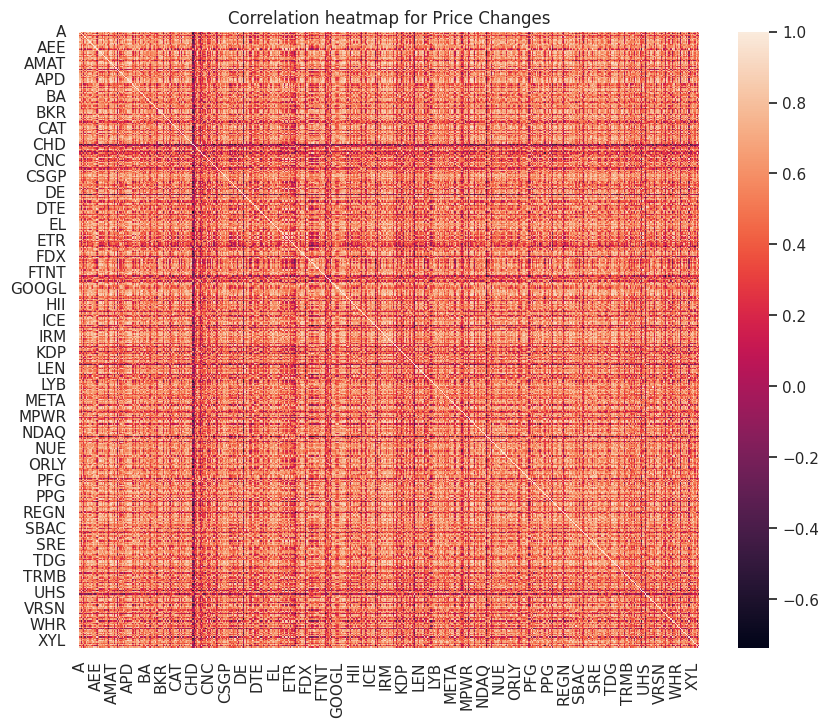

In [27]:
sns.heatmap(price_corr).set_title("Correlation heatmap for Price Changes")

### <font color= "9900CC">**Examining correlations further**

In [28]:
df_price_pct['JPM'].head()

2023-03-03    0.018360
2023-03-06   -0.005847
2023-03-07   -0.029408
2023-03-08   -0.005915
2023-03-09   -0.054136
Name: JPM, dtype: float64

Text(0, 0.5, 'GOLD SACH')

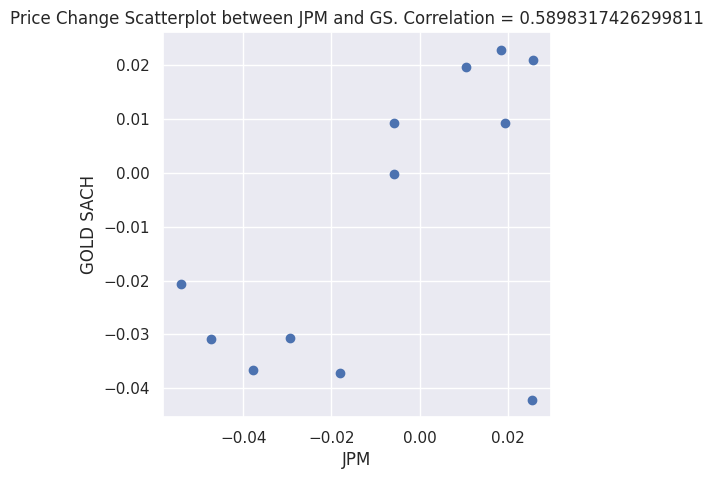

In [29]:
plt.figure(figsize=(5,5))
plt.scatter(df_price_pct['JPM'], df_price_pct['GS'])
plt.title('Price Change Scatterplot between JPM and GS. Correlation = {}'.format(price_corr['JPM']['GS']))

plt.xlabel("JPM")
plt.ylabel('GOLD SACH')

Summary statistics for the df_price_pct and df_volume dataframes and then boxplots to find outliers

In [30]:
df_price_pct.head()

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2023-03-03,0.015952,0.014888,0.035090,0.010882,0.027374,0.017734,0.005642,0.014853,0.031604,0.008993,...,0.021338,0.011812,0.012657,0.028132,0.016333,0.007693,0.026262,0.011076,0.019044,0.011745
2023-03-06,-0.004863,-0.014670,0.018539,-0.004998,0.004772,-0.016276,0.005610,0.001597,0.008662,-0.003919,...,-0.003712,-0.000768,0.008865,0.013681,-0.003368,-0.002853,-0.012676,-0.011763,-0.009547,-0.005218
2023-03-07,-0.020247,0.014888,-0.014497,-0.015134,0.004829,-0.026959,-0.009902,-0.020139,-0.006397,-0.003126,...,-0.019411,-0.022137,-0.019331,-0.017316,-0.013517,-0.018407,-0.011796,-0.011935,-0.047580,-0.015560
2023-03-08,0.004062,0.014059,0.008377,-0.021775,-0.015283,-0.005801,-0.009861,-0.002044,0.003016,0.008814,...,0.003358,0.012419,-0.014604,-0.016585,-0.003915,-0.001103,-0.010069,0.016250,0.005168,0.009639
2023-03-09,-0.013982,-0.042797,-0.014915,-0.015040,-0.041280,-0.015594,-0.027173,-0.014792,-0.021600,-0.016133,...,-0.034437,-0.002329,-0.007729,-0.022661,-0.012675,-0.005758,0.003609,-0.033087,-0.113967,-0.006819


# <font color= "9900CC">Summary Stats and Outliers?
The below box plot is showing the price percentage change averaged across all 500 companies for each day, there's no outliers so it doesn't seem like theres one day in the timeseries where all the companies are all having drastic movement.




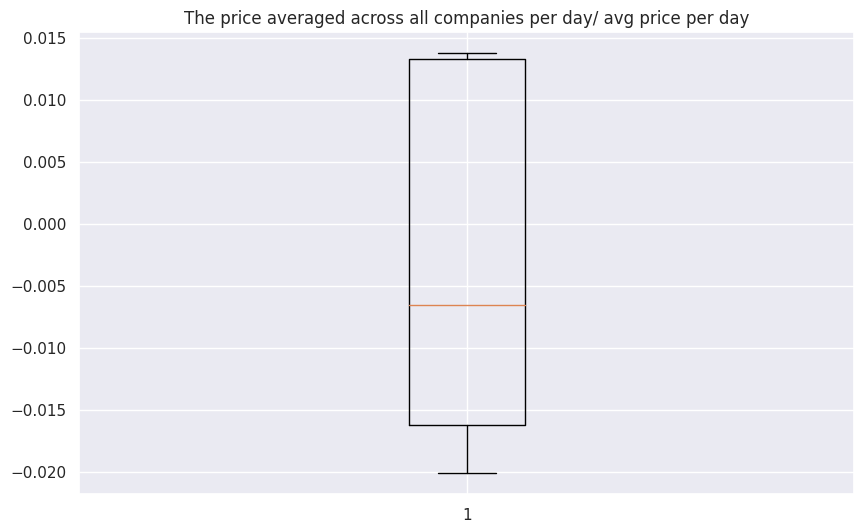

count    12.000000
mean     -0.003695
std       0.014268
min      -0.020077
25%      -0.016185
50%      -0.006542
75%       0.013309
max       0.013795
Name: average, dtype: float64

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))
df_price_plotting = df_price_pct
ax.set(title="The price averaged across all companies per day/ avg price per day")
df_price_plotting['average'] = df_price_plotting.mean(axis=1)
#average across all companies per day



# Creating plot
plt.boxplot(df_price_plotting['average'])

# show plot
plt.show()
df_price_plotting['average'].describe()

In [32]:

#fig, ax = plt.subplots(figsize=(10, 6))
#ax.set(title="The volume averaged across all companies per day/ avg volume per day")
#df_volume_summary_stats = df_volume.describe()
#df_volume_summary_stats['average'] = df_volume_summary_stats.mean(axis=1)
#df_volume_summary_stats['average']


# Creating plot
#plt.boxplot(df_volume_summary_stats['average']) # plot the volume

# show plot
#plt.show()
#df_volume_summary_stats['average'].describe()

### Analyzng the distributions over time

This time instead of averaging every companies price change per day we're going to look at every company's price change over one day and make a separate boxplot to show the changes in distribution across the week of the crash

on march 2nd there was  3  negative outliers and  13 positive outliers in the distribution
on march 9th there was  21  negative outliers and  3 positive outliers in the distribution
on march 15th there was  9  negative outliers and  14 positive outliers in the distribution
on march 19th there was  10  negative outliers and  10 positive outliers in the distribution




[Text(0.5, 1.0, 'Price % changes on march 19th 2023')]

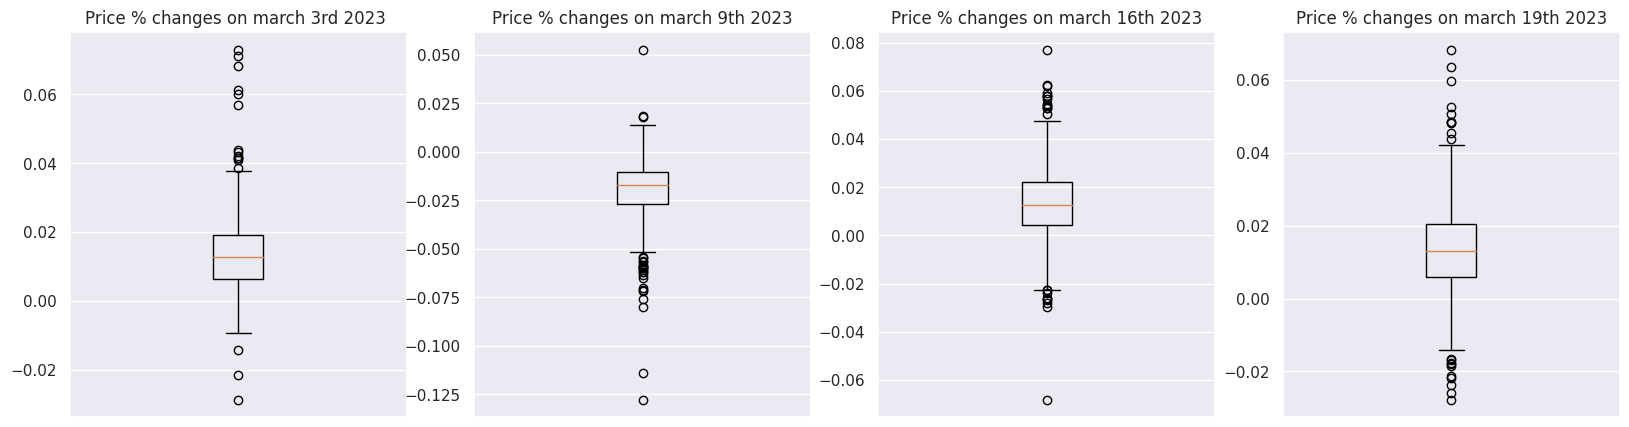

In [33]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(20, 5), ncols=4)
bxplt1 = ax1.boxplot(df_price_pct.loc['2023-03-03'])
bxplt2 = ax2.boxplot(df_price_pct.loc['2023-03-09'])
bxplt3 = ax3.boxplot(df_price_pct.loc['2023-03-16'])
bxplt4 = ax4.boxplot(df_price_pct.loc['2023-03-20'])
ax1.xaxis.set_visible(False)
ax2.xaxis.set_visible(False)
ax3.xaxis.set_visible(False)
ax4.xaxis.set_visible(False)

outliers1 = bxplt1["fliers"][0].get_ydata()
outliers2 = bxplt2["fliers"][0].get_ydata()
outliers3 = bxplt3['fliers'][0].get_ydata()
outliers4 = bxplt4['fliers'][0].get_ydata()

neg_outliers1 = outliers1[outliers1<0]
neg_outliers2 = outliers2[outliers2<0]


print('on march 2nd there was ', len(neg_outliers1), ' negative outliers and ', len(outliers1[outliers1>0]), 'positive outliers in the distribution')
print('on march 9th there was ', len(neg_outliers2), ' negative outliers and ', len(outliers2[outliers2>0]), 'positive outliers in the distribution')
print('on march 15th there was ', len(outliers3[outliers3<0]), ' negative outliers and ', len(outliers3[outliers3>0]), 'positive outliers in the distribution')
print('on march 19th there was ', len(outliers4[outliers4<0]), ' negative outliers and ', len(outliers4[outliers4<0]), 'positive outliers in the distribution\n\n')

ax1.set(title="Price % changes on march 3rd 2023 ")
ax2.set(title="Price % changes on march 9th 2023")
ax3.set(title= "Price % changes on march 16th 2023")
ax4.set(title = "Price % changes on march 19th 2023")


This is also shown in the line graph showing how during the week of the crash, healthcare company ABT stayed consistent with the monthly trends while financial company charles schwab had one of its lowest price drops. Tesla, a silicon tech company had big drop on the 9th but rebounded pretty quickly

I wanted to show how the crash affects other sectors besides financial

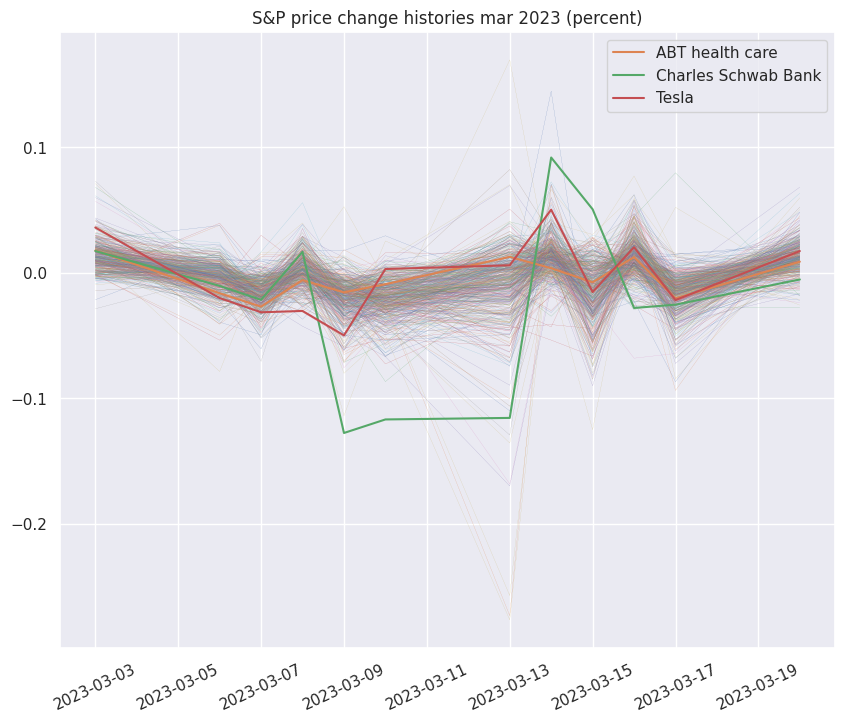

In [34]:
plt.title('S&P price change histories mar 2023 (percent)')
plt.plot(df_price_pct, linewidth=0.10)
plt.plot(df_price_pct['ABT'], label='ABT health care', linewidth=1.5)
plt.plot(df_price_pct['SCHW'], label = 'Charles Schwab Bank', linewidth=1.5)
plt.plot(df_price_pct['TSLA'], label = 'Tesla', linewidth=1.5)
plt.xticks(rotation=25)
plt.legend()

## <font color= "9900CC">**Not every company reacted the same way**
In the original time series used for the file, JPMC and GS's price changes were consistent with each other throughout the month. However, when we set the timeseries to march 2023, during the week of the SVB crash they diverge drastically, this is because while GS suffered due to uncertaintiy w/ the economy, JPMC was in talks to accquire SVB thus their price sky rocketed so you can't definetively say every financial company suffered due to the crash.

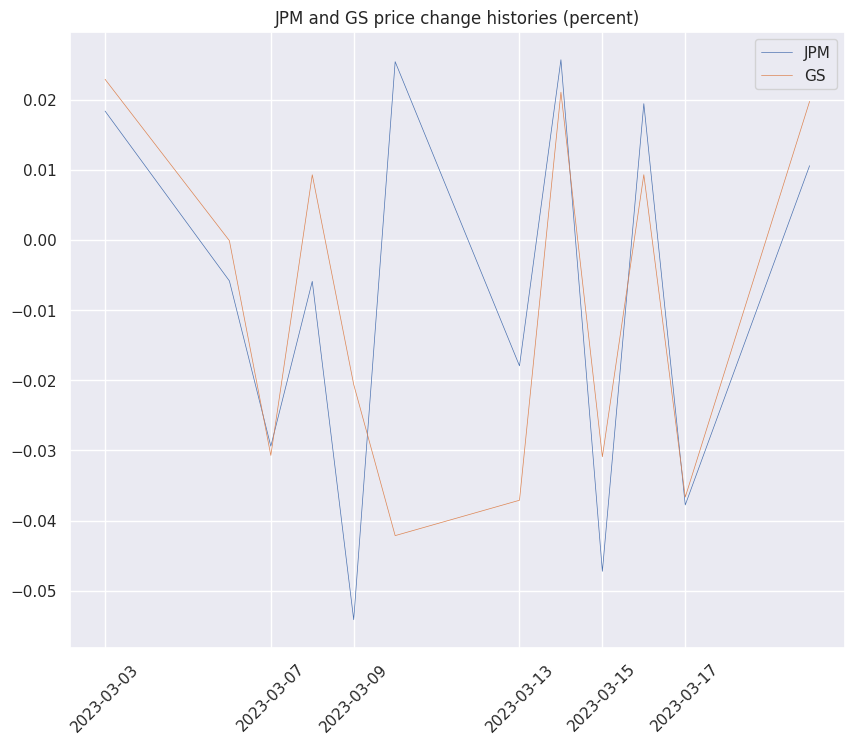

In [35]:
plt.title('JPM and GS price change histories (percent)')
plt.plot(df_price_pct['JPM'], label='JPM', linewidth=0.5)
plt.plot(df_price_pct['GS'], label='GS', linewidth=0.5)
dates = list(df_price_pct.index.values)
plt.xticks([dates[i] for i in range(len(dates)) if i % 2 == 0], rotation=45)
plt.legend()

In [36]:
df_price_pct_summary_stats = df_price_pct.describe()
df_price_pct_summary_stats['average'] = df_price_pct_summary_stats.mean(axis=1)
print('summary statistics for price (not pct change) averaged across all companies')
#df_price_pct_summary_stats.head()
print(df_price_pct_summary_stats['average'])

summary statistics for price (not pct change) averaged across all companies
count    12.000000
mean     -0.003695
std       0.020238
min      -0.037268
25%      -0.017063
50%      -0.003844
75%       0.009746
max       0.029120
Name: average, dtype: float64


## Saving correlation dataframes

In [37]:
#df_price_pct.to_csv(os.path.join(data_dir, 'price_pct.csv'), index_label='date')
price_corr.to_csv(os.path.join(data_dir, 'price_corr.csv'), index_label='Symbol')
volume_corr.to_csv(os.path.join(data_dir, 'volume_corr.csv'))

In [38]:
price_corr

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.518886,0.791645,0.374017,0.633631,0.810016,0.844037,0.907142,0.633081,0.872988,...,0.769744,0.302471,0.665964,0.743985,0.842873,0.723940,0.581280,0.822348,0.232826,0.829994
AAL,0.518886,1.000000,0.363977,-0.151066,0.736561,0.168847,0.642950,0.615691,0.609986,0.667913,...,0.739896,-0.394523,0.452224,0.273454,0.530965,0.064477,0.102182,0.648352,0.545734,0.338238
AAPL,0.791645,0.363977,1.000000,0.431609,0.610113,0.781190,0.553827,0.815994,0.691611,0.642086,...,0.712923,0.532876,0.515754,0.803460,0.644942,0.761709,0.446677,0.716757,0.305478,0.782668
ABBV,0.374017,-0.151066,0.431609,1.000000,0.339876,0.705049,0.322698,0.290108,0.224158,0.327987,...,0.359324,0.294439,0.311518,0.674333,0.404991,0.548517,0.709123,0.218782,0.018601,0.133276
ABNB,0.633631,0.736561,0.610113,0.339876,1.000000,0.482642,0.751249,0.783878,0.845854,0.700262,...,0.805316,-0.174716,0.398855,0.569476,0.545921,0.349105,0.265398,0.693478,0.571563,0.435598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.723940,0.064477,0.761709,0.548517,0.349105,0.813979,0.569091,0.692405,0.584597,0.590949,...,0.566739,0.628206,0.454164,0.549113,0.719981,1.000000,0.605335,0.703823,0.322230,0.755965
ZBH,0.581280,0.102182,0.446677,0.709123,0.265398,0.726603,0.468681,0.430972,0.231294,0.453410,...,0.488025,0.171738,0.605129,0.648118,0.712134,0.605335,1.000000,0.356335,0.145916,0.292401
ZBRA,0.822348,0.648352,0.716757,0.218782,0.693478,0.631934,0.762803,0.806578,0.801995,0.913041,...,0.848672,0.262201,0.384179,0.499870,0.725554,0.703823,0.356335,1.000000,0.571482,0.767484
ZION,0.232826,0.545734,0.305478,0.018601,0.571563,0.089374,0.484665,0.416105,0.626160,0.371718,...,0.636502,-0.284170,0.238859,0.086018,0.447629,0.322230,0.145916,0.571482,1.000000,0.086201


# <font color = "333CFF">Creating Graphs

I want to create differnt graphs so this one will be the main one using all the correlation values

## <font color = "6820EE">Heat Maps

In [43]:
symbols_array = np.array(symbols)
symbols_array

array(['A', 'AAL', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE',
       'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG',
       'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'AMAT',
       'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS',
       'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'ATVI',
       'AVB', 'AVGO', 'AVY', 'AWK', 'AXON', 'AXP', 'AZO', 'BA', 'BAC',
       'BALL', 'BAX', 'BBWI', 'BBY', 'BDX', 'BEN', 'BF.B', 'BG', 'BIIB',
       'BIO', 'BK', 'BKNG', 'BKR', 'BLK', 'BMY', 'BR', 'BRK.B', 'BRO',
       'BSX', 'BWA', 'BX', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB',
       'CBOE', 'CBRE', 'CCI', 'CCL', 'CDAY', 'CDNS', 'CDW', 'CE', 'CEG',
       'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX',
       'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF',
       'COO', 'COP', 'COR', 'COST', 'CPB', 'CPRT', 'CPT', 'CRL', 'CRM',
       'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTLT', 'CTRA', 'CTSH

Text(0.5, 1.0, 'Correlation heatmap for Price Changes')

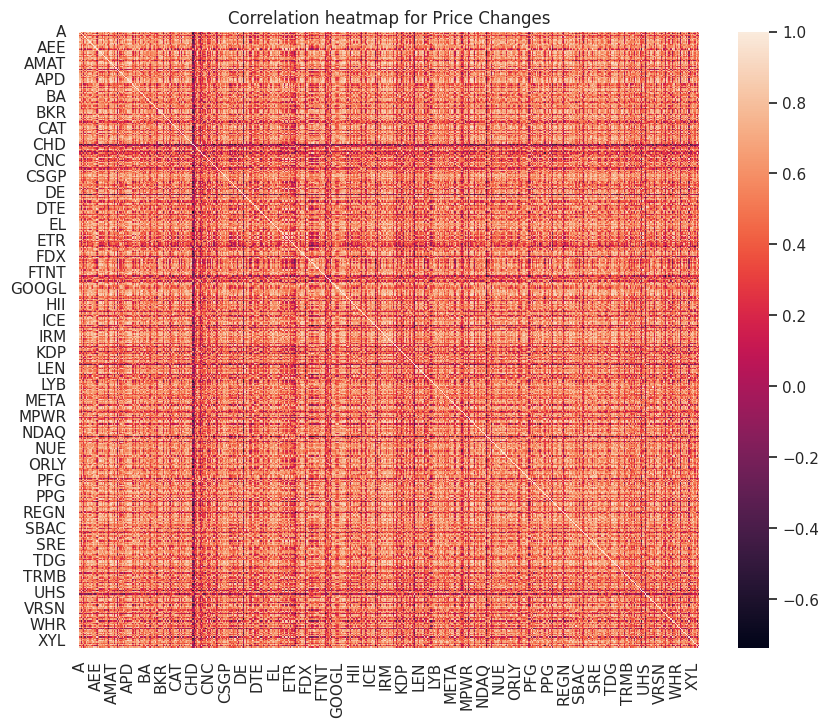

In [45]:
sns.heatmap(price_corr).set_title("Correlation heatmap for Price Changes")

In [72]:
df_industry = pd.DataFrame({"Sectors": industries, "Company": symbols})

In [73]:
df_industry

,Sectors,Company
0,Industrials,A
1,Industrials,AAL
2,Health Care,AAPL
3,Health Care,ABBV
4,Information Technology,ABNB
...,...,...
498,Consumer Discretionary,YUM
499,Information Technology,ZBH
500,Health Care,ZBRA
501,Financials,ZION


In [83]:
unique_sectors = df_industry['Sectors'].unique()
print(unique_sectors)
len(unique_sectors)

['Industrials' 'Health Care' 'Information Technology'
 'Communication Services' 'Consumer Staples' 'Utilities' 'Financials'
 'Consumer Discretionary' 'Materials' 'Real Estate' 'Energy']


11

In [111]:
#creating conditions

#Industrials
condition_industrials = 'Industrials'
industrials_append = []

#Health Care
condition_health_care = 'Health Care'
health_care_append = []

#Information Technology
condition_info_tech = 'Information Technology'
info_tech_append = []

#Communication Services
condition_comm = 'Communication Services'
comm_append = []

#Consumer Staples
condition_con_stap = 'Consumer Staples'
con_stap_append = []

#Utilities
condition_utilities = 'Utilities'
utilities_append = []

#Financials
condition_fin = 'Financials'
fin_append = []

#Consumer Discretionary
condition_con_dis = 'Consumer Discretionary'
con_dis_append = []

#Materials
condition_materials = 'Materials'
materials_append = []

#Real Estate
condition_real_estate = 'Real Estate'
real_estate_append = []

#Energy
condition_energy = 'Energy'
energy_append = []

In [113]:
for sector, company in df_industry.iterrows():

  if condition_industrials in company['Sectors']:
    industrials_append.append(company['Company'])

  if condition_health_care in company['Sectors']:
    health_care_append.append(company['Company'])

  if condition_info_tech in company['Sectors']:
    info_tech_append.append(company['Company'])

  if condition_comm in company['Sectors']:
    comm_append.append(company['Company'])

  if condition_con_stap in company['Sectors']:
    con_stap_append.append(company['Company'])

  if condition_utilities in company['Sectors']:
    utilities_append.append(company['Company'])

  if condition_fin in company['Sectors']:
    fin_append.append(company['Company'])

  if condition_con_dis in company['Sectors']:
    con_dis_append.append(company['Company'])

  if condition_materials in company['Sectors']:
    materials_append.append(company['Company'])

  if condition_real_estate in company['Sectors']:
    real_estate_append.append(company['Company'])

    if condition_energy in company['Sectors']:
      energy_append.append(company['Company'])

,Industrials
0,A
1,AAL
2,A
3,AAL
4,ADBE
...,...
72,VRSK
73,WBA
74,WELL
75,XEL


In [126]:
#I am creating the df for each sector
df_1 = pd.DataFrame({"Industrials": industrials_append})
df_2 = pd.DataFrame({"Health Care": health_care_append})
df_3 = pd.DataFrame({"Information Technology": info_tech_append})
df_4 = pd.DataFrame({"Communication Services": comm_append})
df_5 = pd.DataFrame({"Consumer Staples": con_stap_append})
df_6 = pd.DataFrame({"Utilities": utilities_append})
df_7 = pd.DataFrame({"Financials": fin_append})
df_8 = pd.DataFrame({"Consumer Discretionary": con_dis_append})
df_9 = pd.DataFrame({"Materials": materials_append})
df_10 = pd.DataFrame({"Real Estate": real_estate_append})
df_11 = pd.DataFrame({"Energy": energy_append})


## Calculaltion Correlation For the Different Sectors

In [124]:
price_corr

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.518886,0.791645,0.374017,0.633631,0.810016,0.844037,0.907142,0.633081,0.872988,...,0.769744,0.302471,0.665964,0.743985,0.842873,0.723940,0.581280,0.822348,0.232826,0.829994
AAL,0.518886,1.000000,0.363977,-0.151066,0.736561,0.168847,0.642950,0.615691,0.609986,0.667913,...,0.739896,-0.394523,0.452224,0.273454,0.530965,0.064477,0.102182,0.648352,0.545734,0.338238
AAPL,0.791645,0.363977,1.000000,0.431609,0.610113,0.781190,0.553827,0.815994,0.691611,0.642086,...,0.712923,0.532876,0.515754,0.803460,0.644942,0.761709,0.446677,0.716757,0.305478,0.782668
ABBV,0.374017,-0.151066,0.431609,1.000000,0.339876,0.705049,0.322698,0.290108,0.224158,0.327987,...,0.359324,0.294439,0.311518,0.674333,0.404991,0.548517,0.709123,0.218782,0.018601,0.133276
ABNB,0.633631,0.736561,0.610113,0.339876,1.000000,0.482642,0.751249,0.783878,0.845854,0.700262,...,0.805316,-0.174716,0.398855,0.569476,0.545921,0.349105,0.265398,0.693478,0.571563,0.435598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.723940,0.064477,0.761709,0.548517,0.349105,0.813979,0.569091,0.692405,0.584597,0.590949,...,0.566739,0.628206,0.454164,0.549113,0.719981,1.000000,0.605335,0.703823,0.322230,0.755965
ZBH,0.581280,0.102182,0.446677,0.709123,0.265398,0.726603,0.468681,0.430972,0.231294,0.453410,...,0.488025,0.171738,0.605129,0.648118,0.712134,0.605335,1.000000,0.356335,0.145916,0.292401
ZBRA,0.822348,0.648352,0.716757,0.218782,0.693478,0.631934,0.762803,0.806578,0.801995,0.913041,...,0.848672,0.262201,0.384179,0.499870,0.725554,0.703823,0.356335,1.000000,0.571482,0.767484
ZION,0.232826,0.545734,0.305478,0.018601,0.571563,0.089374,0.484665,0.416105,0.626160,0.371718,...,0.636502,-0.284170,0.238859,0.086018,0.447629,0.322230,0.145916,0.571482,1.000000,0.086201


In [134]:
sector_corr_matrices = {}
j=0
for i in range(1, 12):
  sector_name = f'df_{i}'
  sector_df = globals()[sector_name]
  #match the name to the i
  sector_companies = sector_df[unique_sectors[j]]

  #column_name = f"{unique_sectors[j]}_corr"
  valid_names = [name for name in sector_companies if name in price_corr.index]
  sector_corr_matrices[unique_sectors[j]] = price_corr.loc[valid_names, valid_names]
  j=j+1

In [138]:
sector_corr_matrices['Industrials']

,A,AAL,A,AAL,ADBE,AES,AJG,AME,AON,BBWI,...,TTWO,UNP,UPS,URI,USB,VRSK,WBA,WELL,XEL,XYL
A,1.000000,0.518886,1.000000,0.518886,0.633081,0.795474,0.849000,0.877742,0.761865,0.533529,...,0.535092,0.832242,0.605609,0.750775,0.657215,0.717349,0.433170,0.684413,0.302471,0.842873
AAL,0.518886,1.000000,0.518886,1.000000,0.609986,0.438091,0.695826,0.510827,0.603522,0.773014,...,0.540086,0.398133,0.186442,0.738748,0.627854,0.342056,0.064833,0.204035,-0.394523,0.530965
A,1.000000,0.518886,1.000000,0.518886,0.633081,0.795474,0.849000,0.877742,0.761865,0.533529,...,0.535092,0.832242,0.605609,0.750775,0.657215,0.717349,0.433170,0.684413,0.302471,0.842873
AAL,0.518886,1.000000,0.518886,1.000000,0.609986,0.438091,0.695826,0.510827,0.603522,0.773014,...,0.540086,0.398133,0.186442,0.738748,0.627854,0.342056,0.064833,0.204035,-0.394523,0.530965
ADBE,0.633081,0.609986,0.633081,0.609986,1.000000,0.668705,0.785044,0.650221,0.766175,0.495809,...,0.756611,0.719804,0.622922,0.615432,0.638996,0.528719,0.264904,0.476373,0.089689,0.531092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VRSK,0.717349,0.342056,0.717349,0.342056,0.528719,0.744370,0.534211,0.759116,0.506660,0.501924,...,0.338506,0.576361,0.196396,0.584504,0.575082,1.000000,0.662189,0.593656,0.460407,0.747097
WBA,0.433170,0.064833,0.433170,0.064833,0.264904,0.445621,0.162441,0.345481,0.241917,0.180137,...,0.234606,0.338678,0.309228,0.199348,0.270652,0.662189,1.000000,0.406083,0.673354,0.307630
WELL,0.684413,0.204035,0.684413,0.204035,0.476373,0.810142,0.437490,0.625113,0.234739,0.285702,...,0.638462,0.666238,0.493425,0.599678,0.403337,0.593656,0.406083,1.000000,0.670996,0.539121
XEL,0.302471,-0.394523,0.302471,-0.394523,0.089689,0.438405,-0.112451,0.195996,-0.055795,-0.197978,...,0.181499,0.293943,0.353011,-0.037571,-0.091710,0.460407,0.673354,0.670996,1.000000,0.051117


In [129]:
unique_sectors

array(['Industrials', 'Health Care', 'Information Technology',
       'Communication Services', 'Consumer Staples', 'Utilities',
       'Financials', 'Consumer Discretionary', 'Materials', 'Real Estate',
       'Energy'], dtype=object)

## <font color = "EE2085">Creating the Sector Heat Maps

Text(0.5, 1.0, 'Correlation heatmap for Industrials')

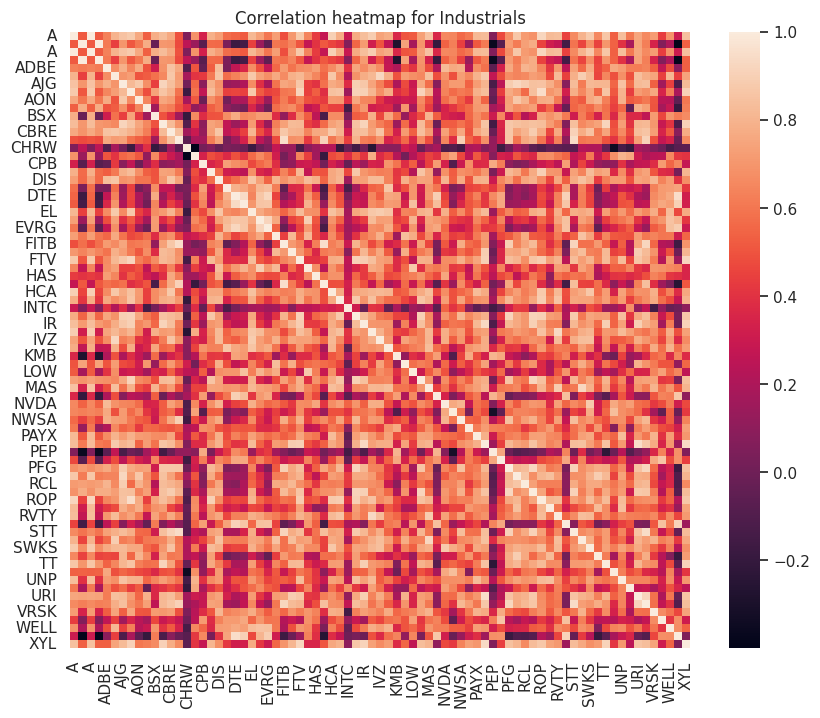

In [136]:
sns.heatmap(sector_corr_matrices['Industrials']).set_title("Correlation heatmap for Industrials")

Text(0.5, 1.0, 'Correlation heatmap for Health Care')

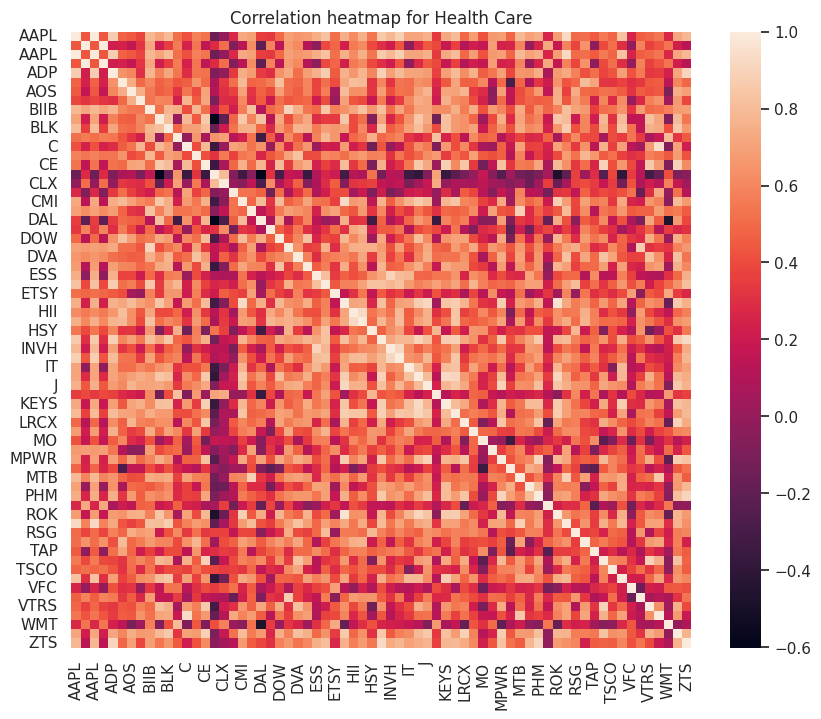

In [137]:
sns.heatmap(sector_corr_matrices['Health Care']).set_title("Correlation heatmap for Health Care")